# Solución del problema de las luces usando el algoritmo de Grover

**Juan Bernardo Benavides y Juan Pablo Vanegas**

---

En este momento, ya algunos compañeros nos han presentado que es qiskit y cómo funciona. En el curso hemos hablado de algunos algoritmos cuánticos y en partícular hemos visto ya en varias ocaciones como funciona el algoritmo de Grover. Sin embargo, hasta ahora no hemos aprovechado la computación cuántica ni las herramientas que nos da IBM para resolver un problema de verdad. Es decir, hasta ahora los planteamientos que hemos hecho del algorítmo de Grover se han enfocado en ver como funciona y probarlo dentro del contexto de un problema de mentiritas en el que ya previamente conocemos la solución. El objetivo el día de hoy es poder ver este algorítmo aplicado en un problema cuya solución no conocemos. 

Iniciamos entonces presentando el problema que queremos solucionar. Este sigue siendo un problema bastante sencillo y que realmente no requiere del uso de la computación cuántica para resolverse, pero nos aporta una forma muy clara de como se puede aplicar el algorítmo de grover en problemas reales cuya solución no conocemos previamente. 

>Entender esto es **fundamental** ya que no importa que tan eficiente sea, un método que requiera conocer la solución al problema que busca solucionar, no sirve para **nada**.

## Outline:

1. [El problema de las luces](#El-problema-de-las-luces)
2. [Recapitulando](#Recapitulando)
    1. [Desarrollo en Qiskit](#Desarrollo-en-Qiskit)
    2. [Algorítmo de Grover](#Algoritmo-de-Grover)
3. [Primera parte.](#Primera-parte)
4. RAM y QRAM.
5. Grover Inception.
6. Segunda parte.
7. Solución final.

## El problema de las luces
<a id="venid_a_mi"></a>

Imaginemos una casa embrujada con 9 cuartos (un solo piso y organizados en una cuadricula de $3\times 3$) y queremos dormir, pero hay algunos cuartos con las luces prendidas. El problema es que hay unos fantasmas que cambian las luces cada cierto tiempo y la única forma de que se queden quietos es apagar todas las luces antes de que las vuelvan a cambiar. Sin embargo, cada vez que muevo un switch de luz hay un fantasma que mueve los switches de los cuartos vecinos. Estudiando un poco la situación, me doy cuenta que los fantasmas no mueven las luces al azar sino que rotan entre 4 configuraciones diferentes de luces. Además, cuando he intentado apagarlos me he dado cuenta que en el tiempo que se demoran en cambiar solamente alcanzo a mover 3 switches y ya cambian a la siguiente configuración. ¿Cómo puedo hacer para apagar las luces y poder irme a dormir?

Este problema lo podemos dividir en 2 partes:

1. Dada una configuración de luces, encontrar la forma de apagar todos los cuartos. 
2. Dadas las 4 configuraciones en las que rotan los fantasmas, encontrar cuál alcanzó a apagar, es decir, cua de las configuraciones se puede resolver con 3 switches o menos.

Este es un caso de un tipo de problema muy famoso conocido como "Light's Out Puzzle". Para trabajarlo, vamos a considerar una cuadricula, en donde cada celda puede contener un dígito binario, entonces una configuración dada de luces vendrá dada en un arreglo unidimensional binario del tipo: 

```python
lights = [0, 0, 0, 1, 0, 1, 1, 1, 0]
```

En el que `0` representa una luz apagada y `1` representa una luz prendida. Este ejemplo se puede resolver simplemente moviendo los switches 0, 3 y 4 como se muestra en la siguiente imagen:

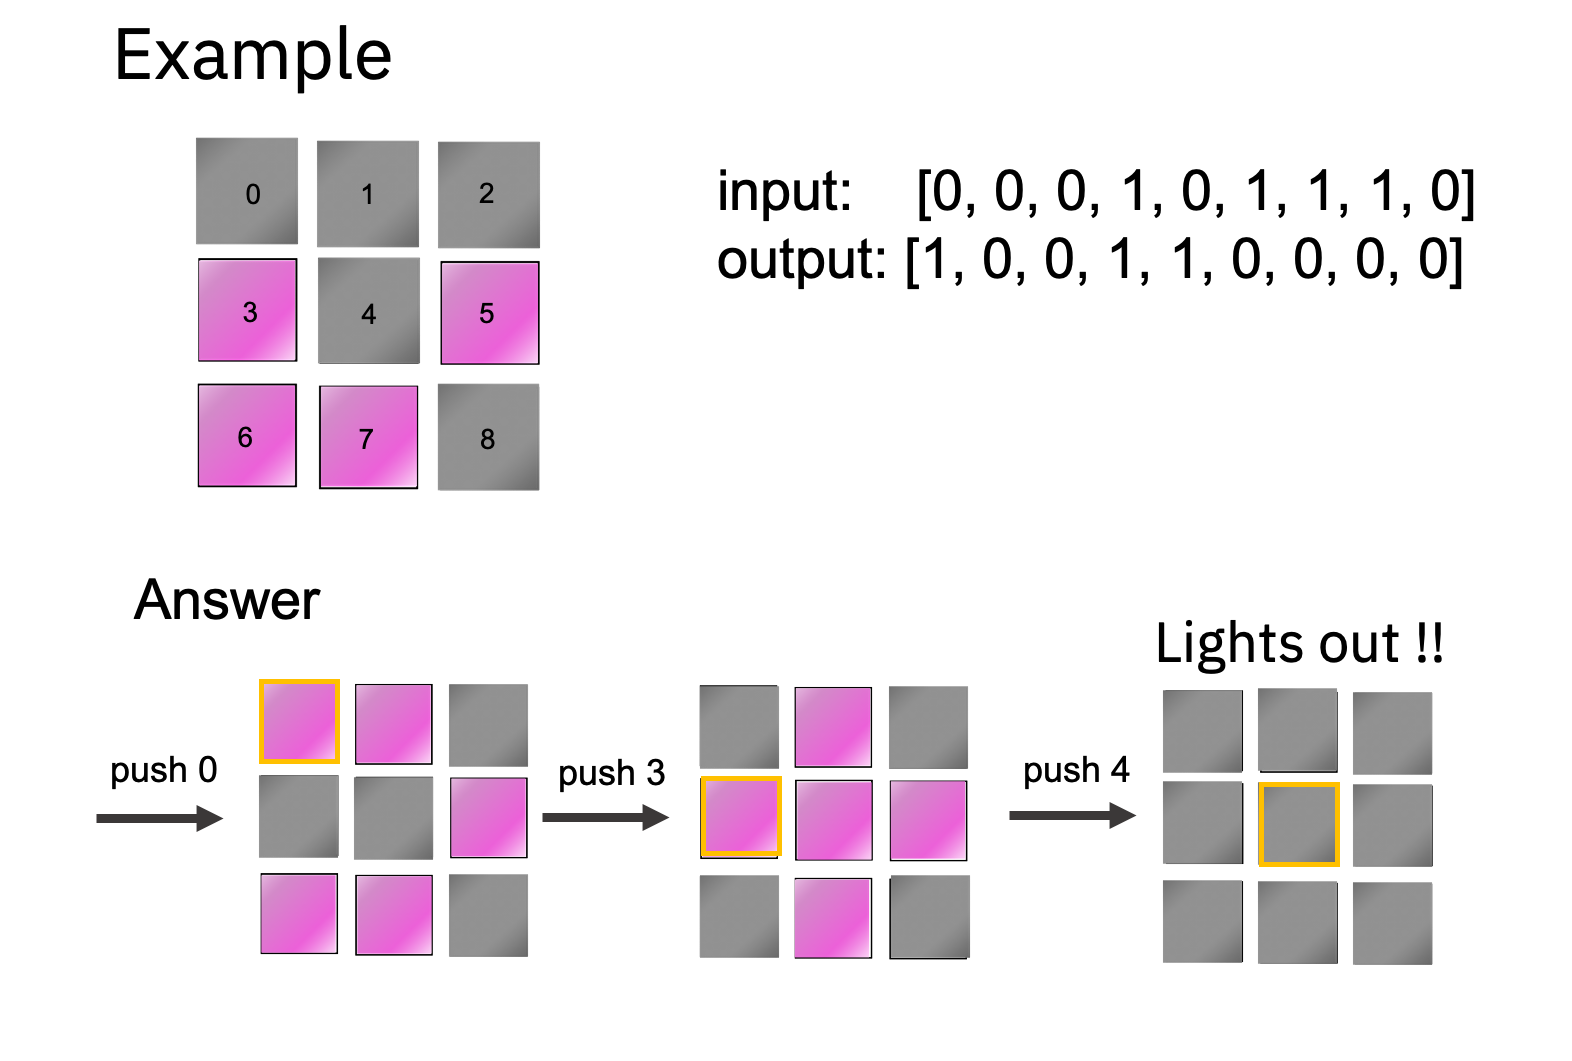

In [6]:
from IPython.display import Image, display
Image('lights_out_rule.png')

Trabajandole un poco, es posible darse cuenta de 2 propiedades:

1. **Un interruptor no se debe mover más de una vez.**

    Esto se debe a que repetir un interruptor es simplemente cancelar el movimiento anterior. 

2. **El orden no importa.**

    El mover el  interruptor al tiene un efecto independiente sobre esa celda y las vecinas que se suma con el efecto de los demás interruptores, pero no se ve afectado por el orden.
    
Por lo tanto, es posible, como se muestra en la imagen, representar la solución en un arreglo similar en el que ahora el 1 representa cuales son los interruptores que se deben presionar para solucionar el problema. 

A pesar de que hay muchas formas de solucionar el problema, en este caso usaremos el algorítmo de Grover para hallar la solución. Para esto debemos primero resolver la primera parte tal que dada una configuración, se encuentre la solución al problema. Luego, encontrar una forma de contar el número de switches que se deben mover en una solución dada. Después debemos encontrar una forma en la que podamos dar un input de 4 tableros diferentes para lo que estudiaremos el concepto de qRAM y por último debemos juntar todo en un circuito tal que dada una lista de 4 configuraciones de luces, identifiquemos cual puede resolverse con menos de 3 interruptores y cual es la solución. 

> ¡Finalmente podremos apagar las luces e ir a dormir!

Antes de pasar a solucionar, veamos una pequeña recapitulación de lo que ya sabemos:

## Recapitulando


### Desarrollo en Qiskit

Qiskit es una librería de python que permite hacer simulaciones de sistemas cuánticos y pues es muy chévere.

In [11]:
# Initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# Import basic plot tools
from qiskit.tools.visualization import plot_histogram

Qiskit nos permite construir un circuito cuantico, y hacer todo lo que ya sabemos hacer, pero de verdad:

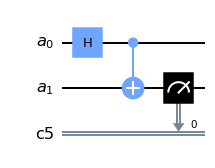

In [12]:
# Crear un circuito con dos qbits y un bit
q = QuantumRegister(2, name="a")
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

# Compuertas
qc.h(q[0])
qc.cx(q[0], q[1])

# Medicion
qc.measure(q[1], c[0])

qc.draw(output="mpl")


{'0': 491, '1': 509}


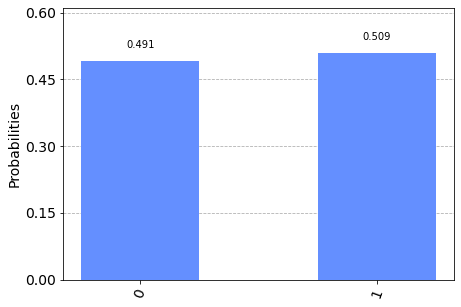

In [13]:
# simular y ver los resultados
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
result = job.result()
count = result.get_counts()
print(count)
plot_histogram(count)


{'0': 495, '1': 505}


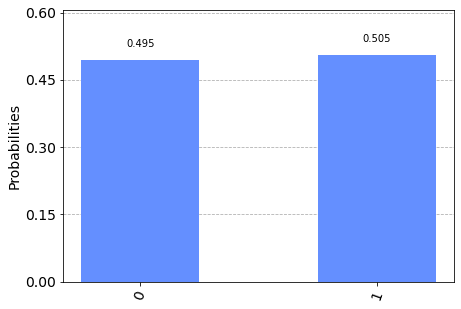

In [14]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
result = job.result()
count = result.get_counts()
print(count)
plot_histogram(count)

### Algorítmo de Grover

In [22]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

## Primera parte

Recordemos un poco el problema. Nos dan una entrada que consiste en una configuración de luces, en el proceso usaremos la siguiente entrada para probar. Esta corresponde al ejemplo que mostramos arriba.

In [16]:
lo = [0,0,0,1,0,1,1,1,0]

Como dijimos, el algoritmo de grover consiste en que dada una posible solución yo debo verificar si esta si es una solución a mi problema entonces el primer paso es implementar una función clásica $f(x)$ tal que:

$$
f(x) = \begin{cases}
    1,& \text{if } x \text{ solves the puzzle} \\
    0,              & \text{if it doesn't}
\end{cases}
$$

donde $x$ representa un estado de 9 qubits que sean una posible solución.

Luego, construyamos un circuito que tenga 9 qubits para la configuracion de las luces estos se inicializaran en `0`o `1` según corresponda al tablero del input y 9 qubits que serán los de la posible solución. Dado que la posible solución lo que nos da es un 1 en el interruptor que debe moverse, se puede usar estos bits como un control que si es 1, entonces cambie el estado de las celdas correspondientes a si misma y sus vecinas en los bits del tablero. Es decir, usar una serie de compuertas CNOT que hagan esto. Una vez apliquemos esto a cada una de las entradas debemos verificar si se apagaron las luces, esto sucede si, después de aplicar estos cambios, todos los qubits correspondientes a tablero están en 0. Para tendremos un qubit auxiliar que arranca en 0 y se voltea a uno solamente si todos los bits del tablero son 0 después de aplicar la solución. Entonces si medimos este qubit al final, cumplirá la caracteristica que buscabamos en la solución. Recordemos que después si este qubit auxiliar se alista en estado $|- \rangle$ tendremos un proceso de 'phase kickback' en el que en lugar de obtener el resultado en el bit auxiliar, el resultado es cambiar la fase del estado que queremos, es decir, se obtiene el oraculo del problema que me deja la amplitud igual para los que no son solución, pero le invierte la fase a los que si son una solución. 

En primer lugar, identifiquemos cuales son las celdas vecinas de una celda dada, es decir, dado que se mueve la celda `i`, ¿cuáles son los indices de los vecinos que se deben mover?

In [18]:
"""
Works for any NxN matrix that is given in a one dimensional array

@param i: index of 1D Array
@param N: size of square matrix

@returns adjacent: list of index in adjacent positions (closed boundaries)
"""
def get_adjacent(i, N):
    column = i % N
    row = i // N
    
    indexes = [i]
    
    if column != 0:
        indexes.append(i-1)
    if column != N-1:
        indexes.append(i+1)
    if row != 0:
        indexes.append(i-N)
    if row != N-1:
        indexes.append(i+N)
    
    return indexes

Ahora, implementemos el circuito:

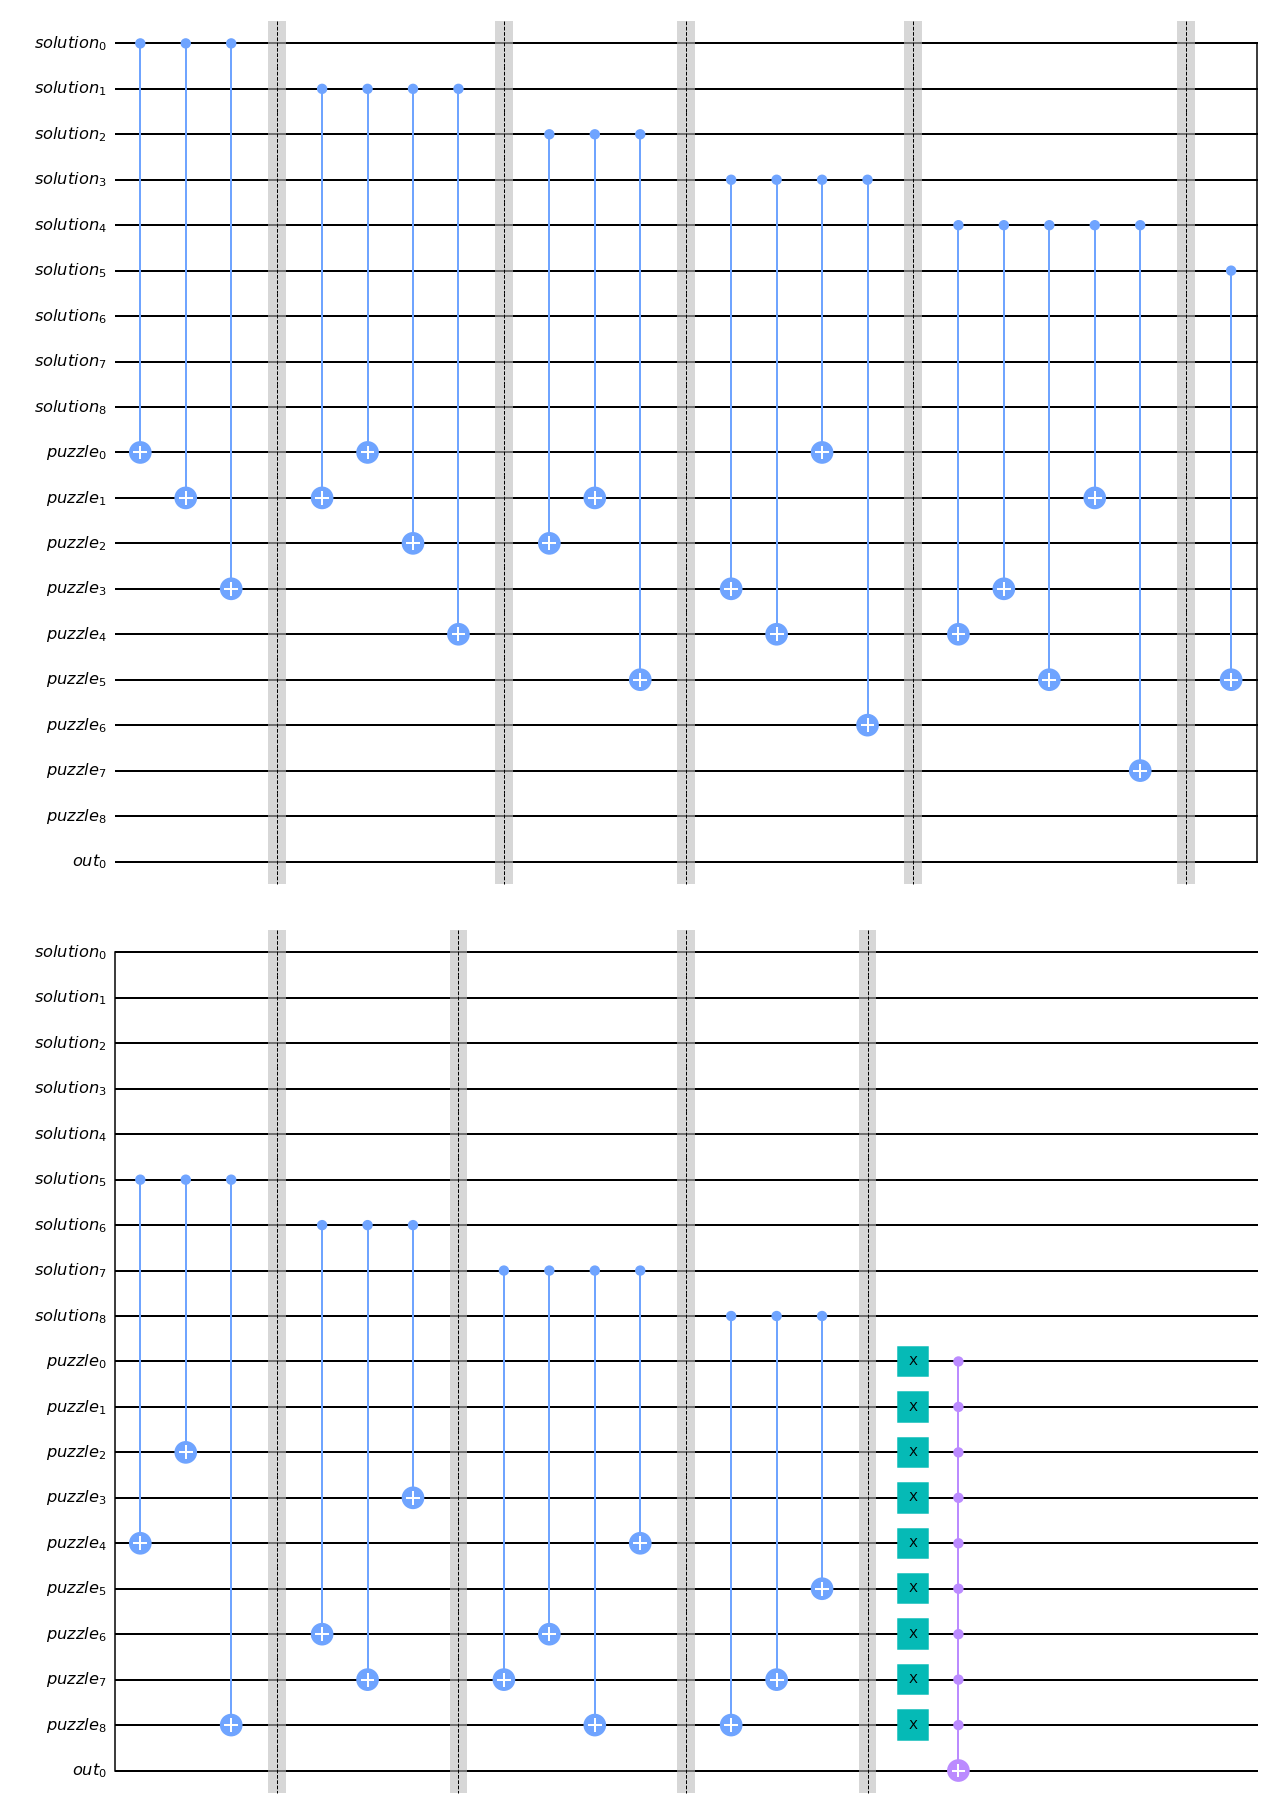

In [20]:
v = QuantumRegister(9, name='solution')
c = QuantumRegister(9, name='puzzle')
o = QuantumRegister(1, name='out')
qc = QuantumCircuit(v, c, o)

N = 3

for i in range(N*N):
    adj = get_adjacent(i, N)
    
    for j in adj:
        qc.cx(v[i], c[j])
    
    qc.barrier() # Just for visual help while designing the circuit

qc.x(c)
qc.mct(c, o)


qc.draw(output='mpl')

Finalmente, es importante hacer un proceso de descomputación que me devuelva los qubits del tablero al estado inicial, esto es necesario para poder aplicar el "phase kickback" que necesitamos para nuestro oráculo. Dado que las compuertas NOT y CNOT son su propia inversa, entonces este proceso consiste simplemente en volver a correr el mismo proceso de forma inversa.

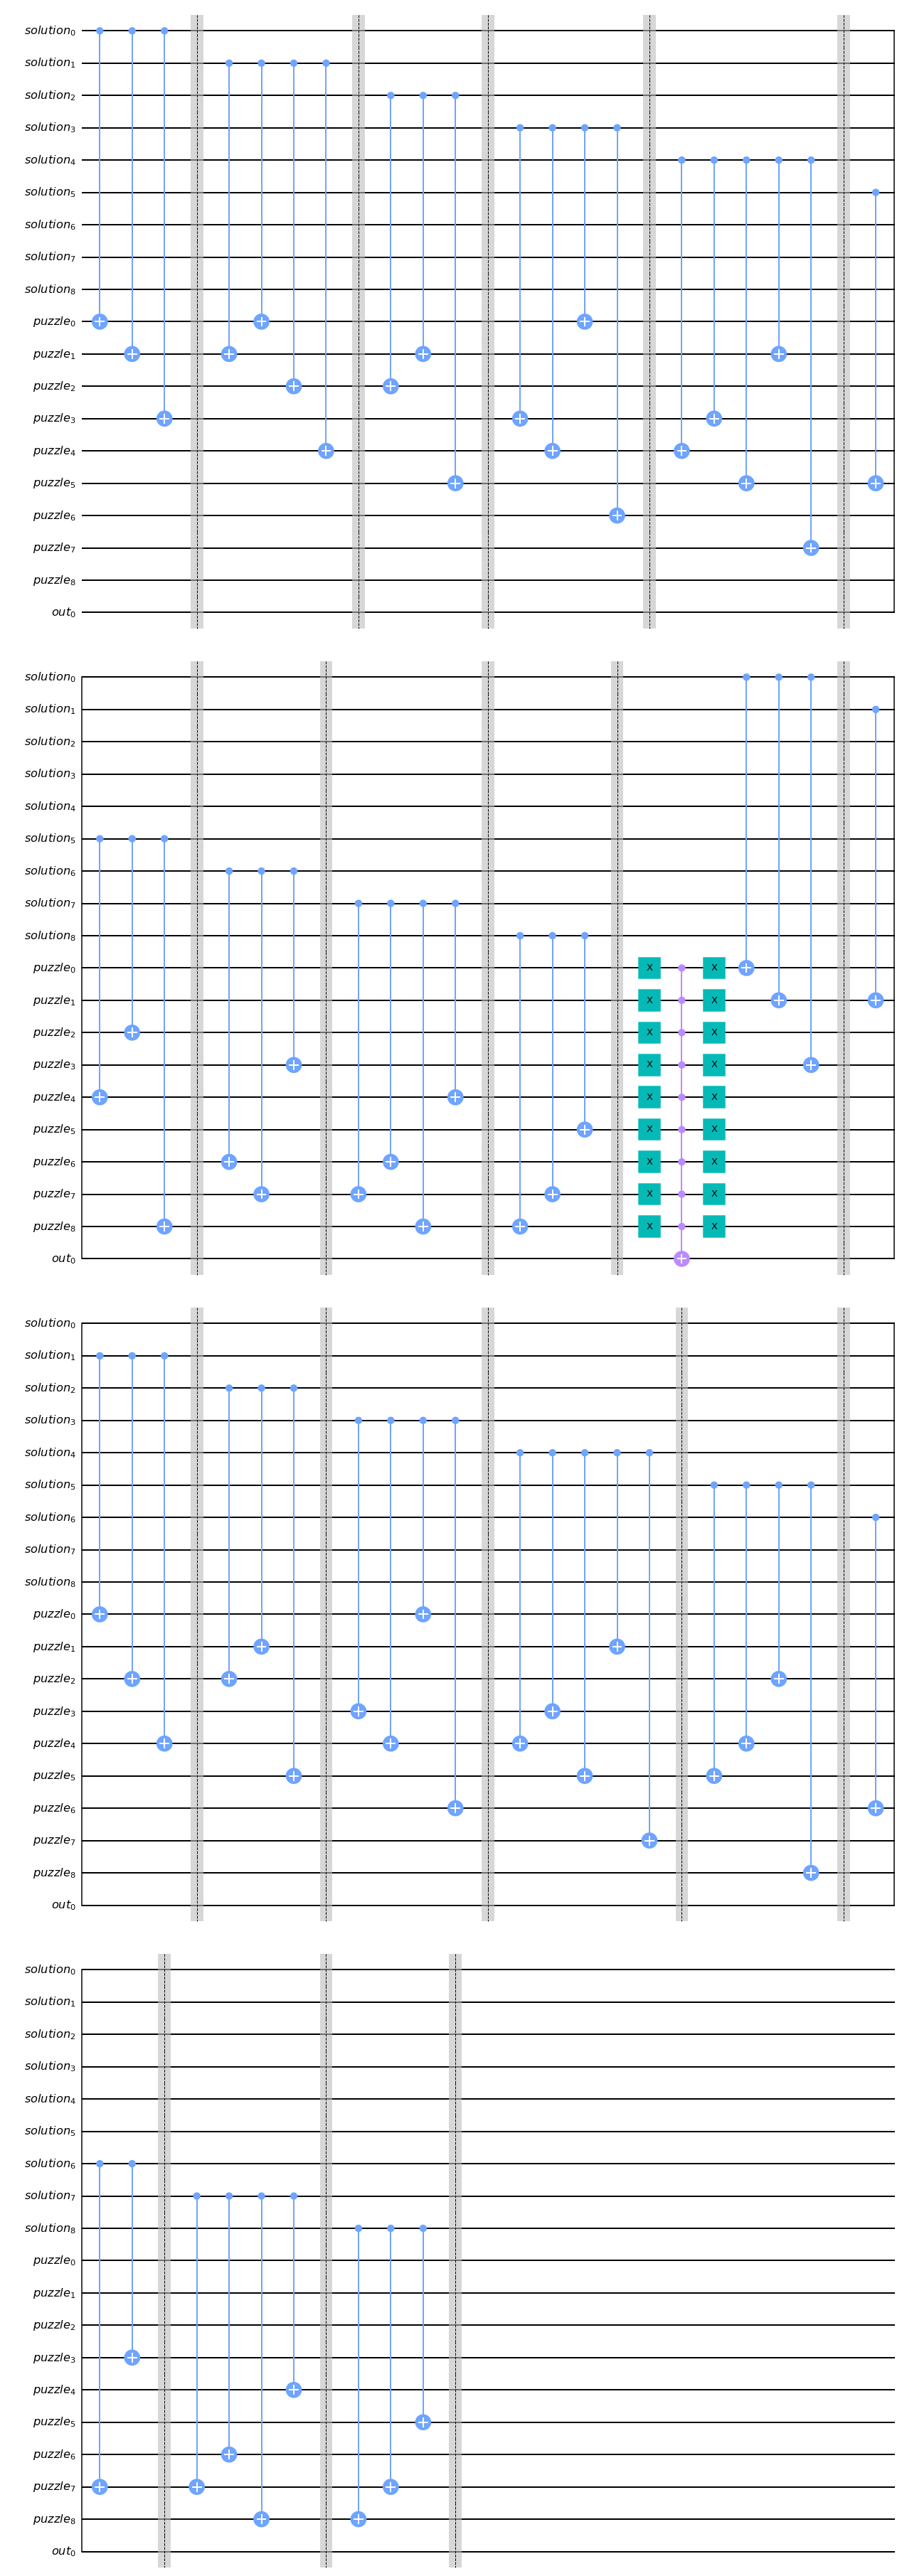

In [21]:
v = QuantumRegister(9, name='solution')
c = QuantumRegister(9, name='puzzle')
o = QuantumRegister(1, name='out')
qc = QuantumCircuit(v, c, o)

N = 3

for i in range(N*N):
    adj = get_adjacent(i, N)
    
    for j in adj:
        qc.cx(v[i], c[j])
    
    qc.barrier() # Just for visual help while designing the circuit

qc.x(c)
qc.mct(c, o)
qc.x(c)

for i in range(N*N):
    adj = get_adjacent(i, N)
    
    for j in adj:
        qc.cx(v[i], c[j])
    
    qc.barrier() # Just for visual help while designing the circuit


qc.draw(output='mpl')

Ya con esto tenemos nuestro oraculo y podemos aprovechar las herramientas que nos da qiskit para definir una compuerta cuántica con este oraculo y podamos simplificar el resto de los circuitos solo usando esa compuerta.

In [29]:
def lo_oracle(N):
    # Initialize the circuit needed
    v = QuantumRegister(N)
    c = QuantumRegister(N)
    o = QuantumRegister(1)
    qc = QuantumCircuit(v, c, o)
    
    # Initialize the output to state |->
    qc.x(o)
    qc.h(o)
    
    #Check if the state is a solution
    for i in range(N):
        adj = get_adjacent(i, int(np.sqrt(N)))

        for j in adj:
            qc.cx(v[i], c[j])

    qc.x(c)
    qc.mct(c, o)
    
    # Uncomputation
    qc.x(c)

    for i in range(N):
        adj = get_adjacent(i, int(np.sqrt(N)))

        for j in adj:
            qc.cx(v[i], c[j])
    
    # Return output qubit to state |0>
    qc.h(o)
    qc.x(o)
    
    
    oracle = qc.to_gate()
    oracle.name = "$U_\omega$"
    
    return oracle

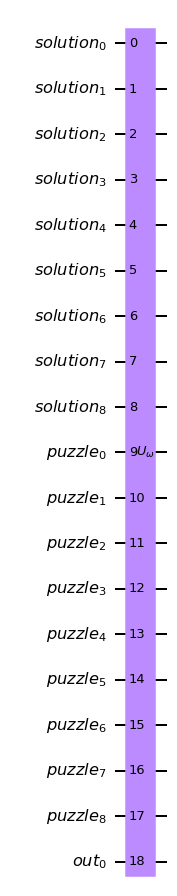

In [30]:
N = 9
v = QuantumRegister(N, name='solution')
c = QuantumRegister(N, name='puzzle')
o = QuantumRegister(1, name='out')
qc = QuantumCircuit(v, c, o)

qc.append(lo_oracle(N), [*v, *c, o])

qc.draw(output='mpl')

Ahora ya con el oraculo podemos proceder a acoplarlo con la compuerta de difusion que teniamos y aplicar el algoritmo de grover.

In [41]:
N = 9
flip_qubits = QuantumRegister(N, name = 'flip')
tile_qubits = QuantumRegister(N, name = 'tile')
output_qubit = QuantumRegister(1, name='o')
cbits = ClassicalRegister(N, name='c')
qc = QuantumCircuit(flip_qubits, tile_qubits, output_qubit, cbits)



# Initialize flip qubits in state |s> and tile qubits in puzzle configuration
qc.h(flip_qubits)

for i, tile in enumerate(lo):
    if tile == 1:
        qc.x(tile_qubits[i])
        
qc.barrier()  # for visual separation

## Iterations
for _ in range(2): 
    # Apply our oracle
    qc.append(lo_oracle(N), [*flip_qubits, *tile_qubits, output_qubit])

    # Apply our diffuser
    qc.append(diffuser(N), flip_qubits)
    
    qc.barrier()  # for visual separation
qc.measure(flip_qubits, cbits)

qc = qc.reverse_bits()

375


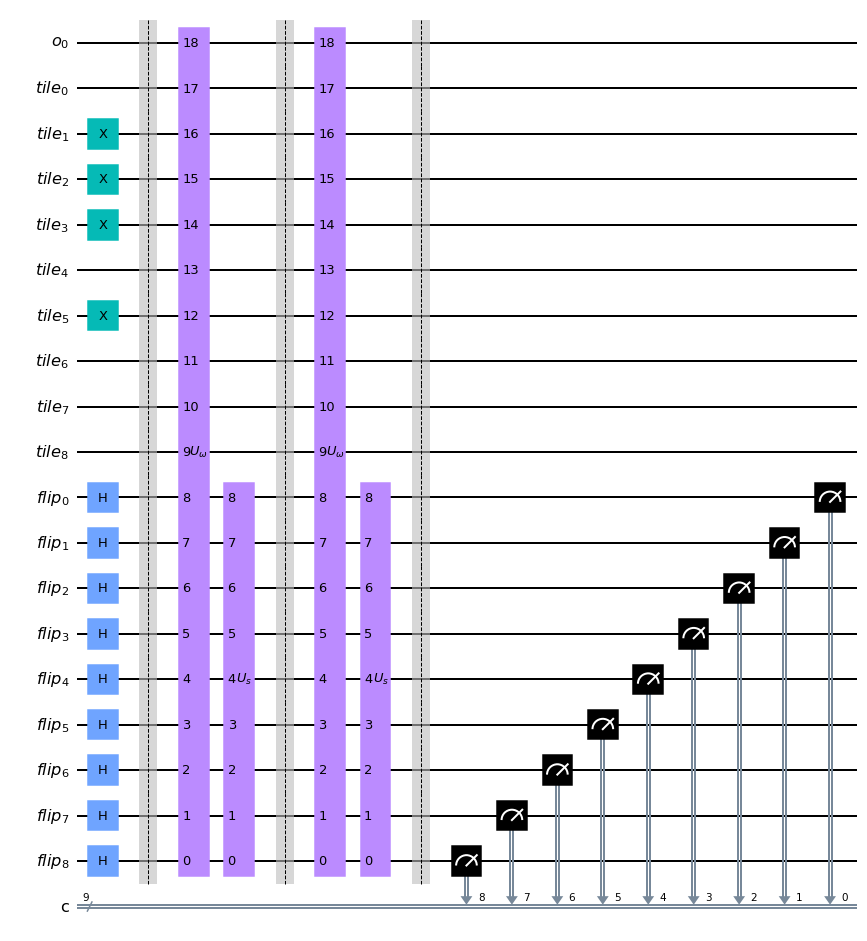

In [42]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, fusion_enable=True)
result = job.result()
count =result.get_counts()
print(count['100110000'])

qc.draw(output='mpl')

Una vez más, definiré una compuerta que me permita simplificar este proceso mas adelante, ya que en el siguiente paso necesitaremos usar esto varias veces. Este será una compuerta que reciba como entrada una configuracion y devuelva la solución en los bits de salida. Esta operacion debe ser unitaria y reversible. Luego, probaremos cuantas iteraciones son necesarias para maximizar la probabilidad de obtener la respuesta correcta, dado que este es un algoritmo que debe correr del orden de $\sqrt(N)$ iteraciones y que en este caso estamos buscando en $2^9 = 512$ posibilidades, y por tanto debemos repetir del orden de $22$ iteraciones. 

In [56]:
def lo_grover(N, niter = 1, dagger=False):
    ##### build your quantum circuit here
    flip_qubits = QuantumRegister(N)
    tile_qubits = QuantumRegister(N)
    aux_qubit = QuantumRegister(1)
    qc = QuantumCircuit(flip_qubits, tile_qubits, aux_qubit)

    # Initialise tile qubits in state |s>
    qc.h(flip_qubits)

    ## Iterations
    for _ in range(niter): 
        # Apply our oracle
        qc.append(lo_oracle(N), [*flip_qubits, *tile_qubits, aux_qubit])

        # Apply our diffuser
        qc.append(diffuser(N), flip_qubits)
    
    
    if dagger:
        qc = qc.inverse()
    
    U2A = qc.to_gate()
    U2A.name = "$LO_{g}$"
    if dagger:
        U2A.name = "$LO_{g}^\dagger$"
        
    return U2A

Text(0, 0.5, '# of times the solution was obtained')

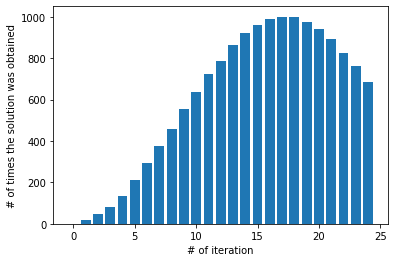

In [48]:
backend = Aer.get_backend('qasm_simulator')
prob_of_ans = []


for j in range(25):
    var_qubits = QuantumRegister(9, name='flip')
    puzzle_qubits = QuantumRegister(9, name='tiles')
    output_qubit = QuantumRegister(1, name='out')
    cbits = ClassicalRegister(9, name='cbits')
    qc = QuantumCircuit(var_qubits, puzzle_qubits, output_qubit, cbits)
    
    for i, tile in enumerate(lo):
        if tile == 1:
            qc.x(puzzle_qubits[i])
    
    qc.append(lo_grover(9, j), [*var_qubits, *puzzle_qubits, output_qubit])
    
    qc.measure(var_qubits[:], cbits[:])
    
    qc = qc.reverse_bits()

    job = execute(qc, backend=backend, shots=1000, seed_simulator=12345, fusion_enable = True)
    result = job.result()
    count =result.get_counts()
    answer = count['100110000']
    prob_of_ans.append(answer)
    
iteration = [i for i in range(25)]
correct = prob_of_ans
plt.bar(iteration, correct)
plt.xlabel('# of iteration')
plt.ylabel('# of times the solution was obtained')

Probemos entonces con una entrada diferente de la que no conozcamos el resultado:

In [52]:
lo = [0, 1, 1, 1, 0, 0, 1, 1, 1]

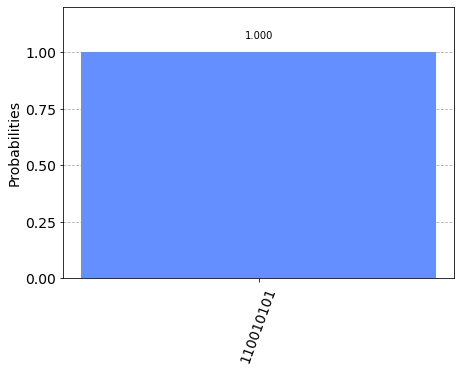

In [54]:
var_qubits = QuantumRegister(9, name='flip')
puzzle_qubits = QuantumRegister(9, name='tiles')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(9, name='cbits')
qc = QuantumCircuit(var_qubits, puzzle_qubits, output_qubit, cbits)

for i, tile in enumerate(lo):
    if tile == 1:
        qc.x(puzzle_qubits[i])

qc.append(lo_grover(9, 17), [*var_qubits, *puzzle_qubits, output_qubit])

qc.measure(var_qubits[:], cbits[:])

qc = qc.reverse_bits()

job = execute(qc, backend=backend, shots=1000, seed_simulator=12345, fusion_enable = True)
result = job.result()
count =result.get_counts()
plot_histogram(count)

## Segunda Parte

Ya habiendo resuelto esta primera parte del problema, podemos voler a revisar la segunda parte con más calma.

Sabemos que los fantasmas rotan en 4 posibles configuraciones, entonces anotamos el estado inicial de cada configuración en un arreglo como el siguiente:

In [57]:
lo4 = [[0,1,0,1,0,0,0,0,0], [1,1,0,1,0,0,0,0,0], [0,1,1,0,0,0,0,0,0], [0,0,1,1,0,0,0,0,0]]

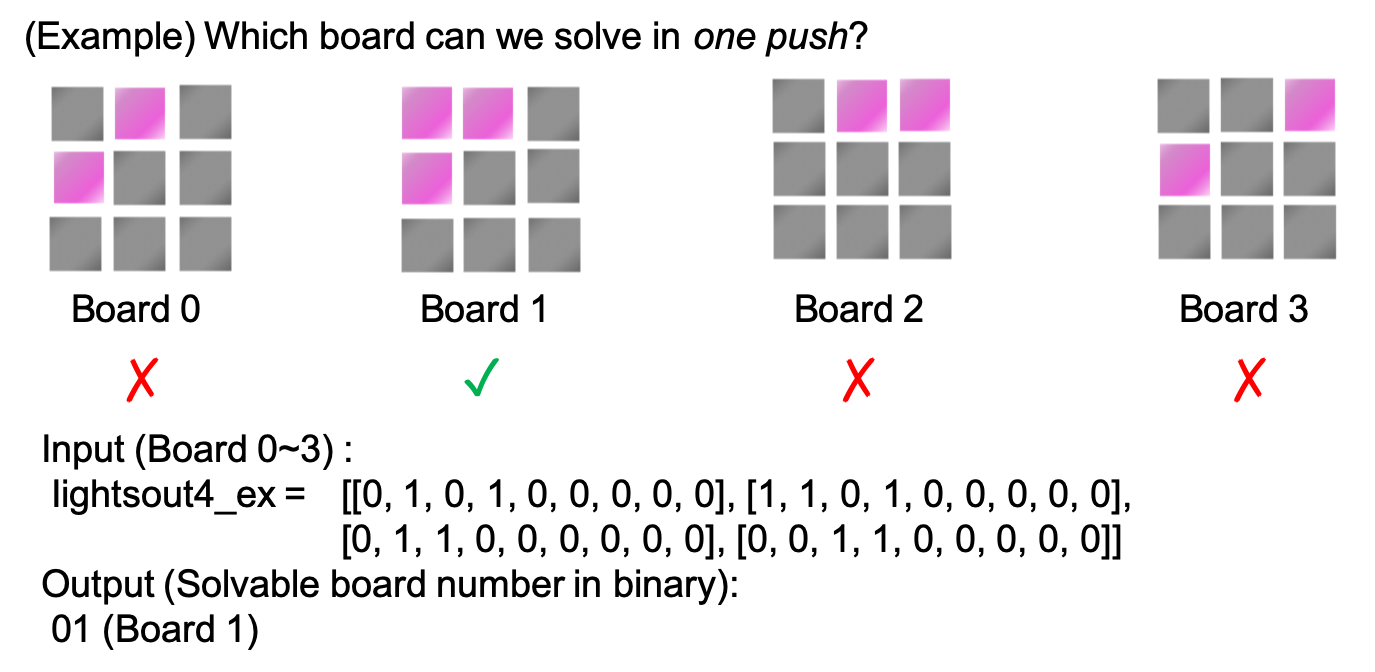

In [55]:
Image('4lightsout_ex.png')

Y nuestro objetivo, como se muestra en la imagen es determinar el número (En binario) del tablero que se puede solucionar en menos de 3. 

## RAM y QRAM
### RAM
La RAM (Random Access Memory) es la memoria inmediata del computador. Algo así como la memoria de trabajo de las personas. 

Carreta

Carreta

### QRAM
¿Y si seguimos en la analogía de no acabar entre clásico y cuántico? ¡Hagamos una RAM cuántica!

Carreta

### Del challenge
In classical computers, RAM (Random Access Memory) is a type of volatile memory that has memory addresses $j$ and stores binary data corresponding to each address $D_j$.

In the case of [qRAM](https://arxiv.org/abs/0708.1879) in a quantum computer, address qubits $a$ have the $N$-addresses as superposition and the corresponding binary data is stored in data qubits $d$ as a state vector.

\begin{equation}
    \sum_{j}\frac{1}{\sqrt{N}}\vert j \rangle_{a}\vert 0 \rangle_{d}\xrightarrow{qRAM}\sum_{j}\frac{1}{\sqrt{N}}\vert j \rangle_{a}\vert D_{j} \rangle_{d}
\end{equation}

We call the right-hand side state "qRAM" and the corresponding gate operation "qRAM operation".

Although qRAM operation requires $\mathcal{O}(N\log N)$ gates, it can be used to create superposition states of binary data intuitively.  

qRAM has previously been applied to various quantum machine learning algorithms such as the HHL algorithm. For this problem, let's apply qRAM to Grover's algorithm.

In [58]:
def bin_string(i, n=4):
    add = bin(i)[2:]
    add = '0'*(n-len(add)) + add
    return add

In [ ]:
address = QuantumRegister(2, name='a')
data = QuantumRegister(9, name = 'd')
c = ClassicalRegister(11)
qc = QuantumCircuit(address,data,c)

# address preparation
qc.h(address[:])
qc.barrier()

for i, puzzle in enumerate(problem_set):
    add = bin_string(i)
    for j, d in enumerate(add):
        if d == '0':
            qc.x(address[j])
            
    for k, tile in enumerate(index_to_board(puzzle)):
        if tile == 1:
            qc.mct(address[:], data[k], mode='noancilla')

    for j, d in enumerate(add):
        if d == '0':
            qc.x(address[j])
            
    qc.barrier()



#Check the qRAM　status
qc.measure(address[0:4], c[0:4])
qc.measure(data[0:16], c[4:20])
 
# Reverse the output string.
qc = qc.reverse_bits()

#backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
#job = execute(qc, backend=backend, shots=8192)
result = job.result()
count =result.get_counts()
print(count)

qc.draw(output='mpl')

Carreta

In [15]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.1',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.1'}